# Chapter 15 - Processing Sequence using RNN and CNN

- RNN are not only types of neural network capable of handling sequence data.
- RNN is like feedforward network except it has a connection backward
- Output from RNN for single instance
    $ y_{t} = \phi (W_{x}^{T} x_{t} + W_{y}^T y_{(t-1)} + b)$
- Many reachers prefer to use "tanh" activation function for RNN than ReLU function

## Memory Cell
- Output of each recurrent neuron at time step "t" is function of input from previous time step - you could say it is a memory.
- A part of neural network that preserves some state across time step is called Memory Cell.
- Single recurrent neuron is basic cell capable of learning only short patterns (about 10 steps long but varies depending on task)
- In general a cell state at anytime "t" is denoted as $h_{t}$ (hidden state)

## Input & Output Sequence
- RNN can take sequence of input and produce sequence of output
- Sequence to Sequence: network is useful in predicting timeseries such as stock market prices
- Sequence to Vector: You can also feed network with series of input with output for last one; e.g. movie rating based on comments
- Vector to Sequence: You can feed same input vector again and again and let output be the sequence; e.g. captioning an image
- Lastly we have sequence to vector network called encoders, followed by vector to sequence network called Decoders; used for translating one language to another. Encoder converts input in one language to vector and decoders convert vectorsto differnt language

## Training RNN on Time series

#### Since RNN takes longer than CNN or Dense networks - we will use Collab workbook for this

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os

Generate time series for given number of steps.

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise

    # Function will return array of shape (Batch Size, Time Steps, 1)
    return series[..., np.newaxis].astype(np.float32)

When dealing with timeseries (and other type of sequence like sentences), the input feature are generally represented in 3D array of shape (Batch size, time steps, dimensionality]. For univariate series dimentionality is usally 1. And more for multivariate series

In [3]:
np.random.seed(42)

n_steps = 50

# generate series of 10000 points for 50 steps
series = generate_time_series(10000, n_steps + 1)

# Create training, validation and test set
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

X_train contains 7000 timeseries while X_valid has 2000 and X_test as 1000. Since we want to forecast a single value from each set, the target column vectors are (7000, 1) for y_train.

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [6]:
X_train[:2]

array([[[ 0.4596948 ],
        [ 0.31486678],
        [ 0.12497123],
        [-0.1039134 ],
        [-0.33817387],
        [-0.53167135],
        [-0.65472883],
        [-0.6680997 ],
        [-0.6068115 ],
        [-0.50168324],
        [-0.27951923],
        [-0.15070675],
        [ 0.01001816],
        [ 0.11860766],
        [ 0.09566415],
        [ 0.1479297 ],
        [ 0.16850619],
        [ 0.19524719],
        [ 0.22094081],
        [ 0.38448656],
        [ 0.4021102 ],
        [ 0.5566975 ],
        [ 0.55000687],
        [ 0.47437248],
        [ 0.29733396],
        [ 0.13306592],
        [-0.1292547 ],
        [-0.36367297],
        [-0.49515054],
        [-0.65279794],
        [-0.6665792 ],
        [-0.5604573 ],
        [-0.50344354],
        [-0.28775147],
        [-0.12684062],
        [-0.0095053 ],
        [ 0.12024356],
        [ 0.18013756],
        [ 0.1559989 ],
        [ 0.1756968 ],
        [ 0.217454  ],
        [ 0.30272725],
        [ 0.38143268],
        [ 0

In [7]:
y_train[:2]

array([[-0.35489398],
       [ 0.11629631]], dtype=float32)

### Plot sets

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

#### Plot for X_train, and y_train

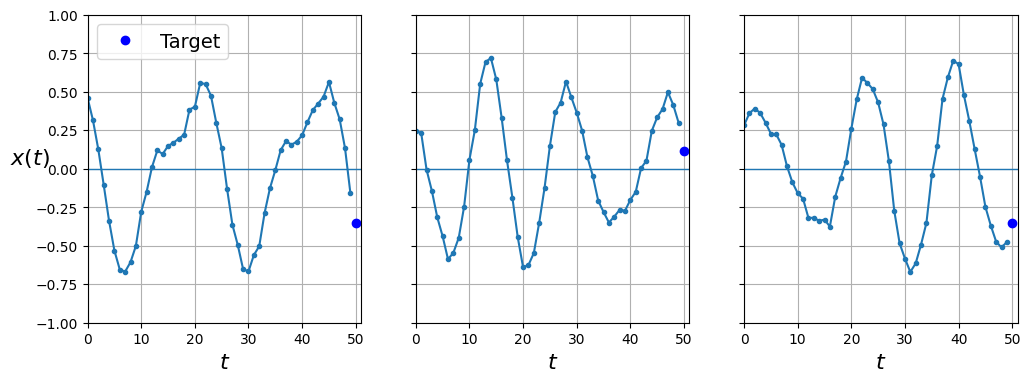

In [10]:
# Create 3 figures
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_train[col, :, 0], y_train[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

#### Plot for X_Valid

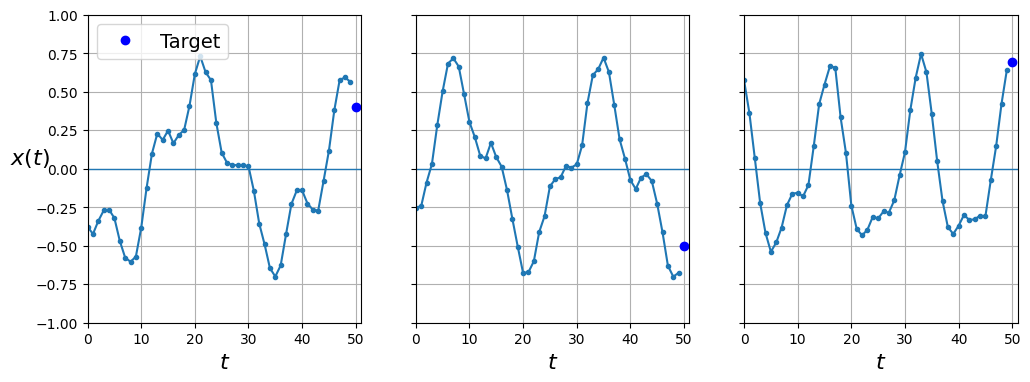

In [11]:
# Create 3 figures
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

#### Plot for X_Test

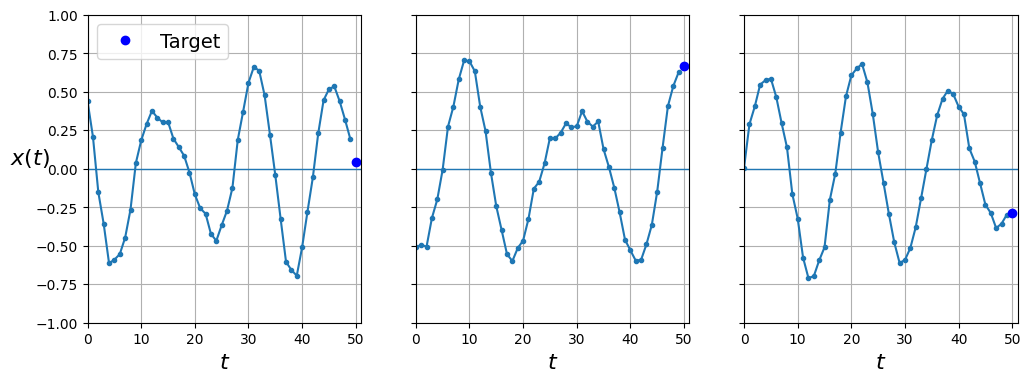

In [12]:
# Create 3 figures
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_test[col, :, 0], y_test[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

### Computing some baselines
To check the performance of our model, we make use of different options.
Option 1: Predict the last value in the series - this is naive forecasting.
Option 2: Use fully connected network (CNN) and perform simple linear regression, so that each prediction is the linear combination of values in the time series;

#### Naive Forecasting Method

In [13]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mse(y_valid, y_pred))

np.float32(0.020211367)

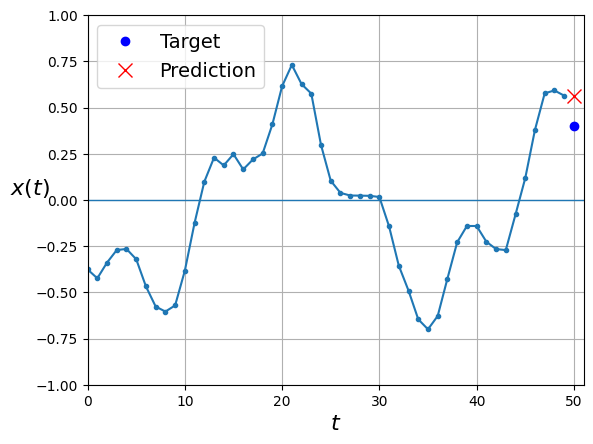

In [14]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Model's Mean squared error is 0.02

### Making prediction using linear regression

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1996 - val_loss: 0.0482
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0351 - val_loss: 0.0170
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0112
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [16]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037


0.0037080212496221066

The model's mean squared error is only 0.0037

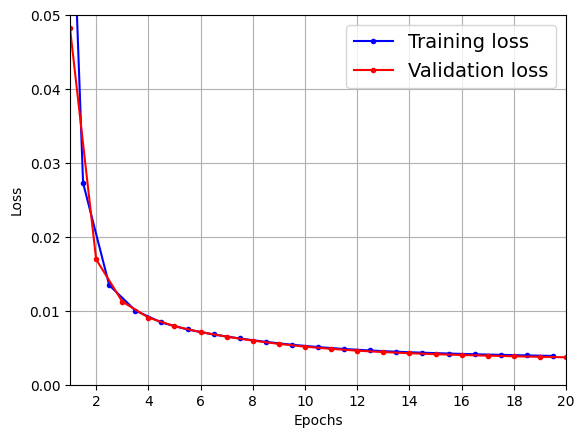

In [18]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


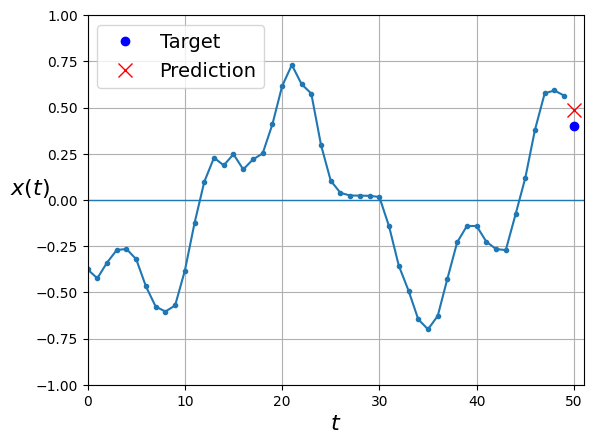

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using Simple RNN

In [20]:
# this is the simplest RNN - single layer with single neuron. No need to specify length of input sequence
# by default simple RNN uses tanh activation function
# by default recurrent layers in keras only return final output. To make them output at every timestep, set return_sequence=True
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)

In [22]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1424 - val_loss: 0.0537
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0426 - val_loss: 0.0270
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245 - val_loss: 0.0193
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184 - val_loss: 0.0155
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0134
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0134 - val_loss: 0.0122
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124 - val_loss: 0.0114
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

In [23]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110


0.010905005037784576

Simple RNN Model with one neuron has MSE of 0.01 which is poor than Linear Regression model.

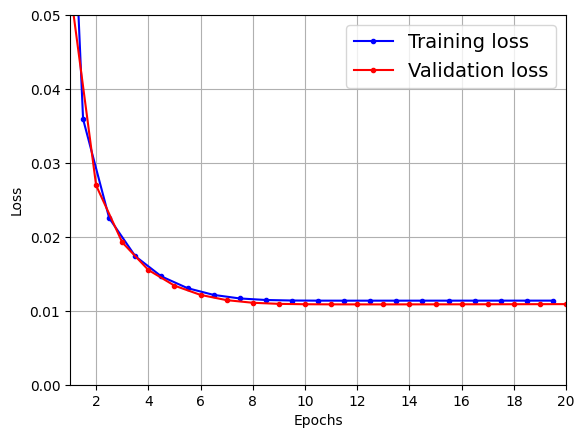

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


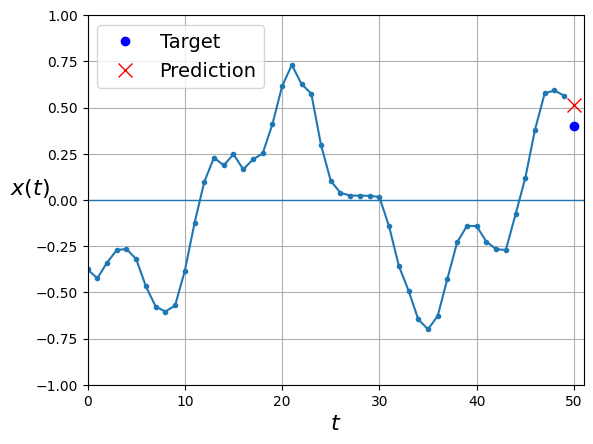

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Deep RNN

Stack up RNN to create Deep RNN. Ensure return_sequences is set to True for all layers except the last one to get 3D array containing output from all timesteps. <br>
If you don't put return_sequence=True for all layers, the Deep network will return result only from the last step which will be 2D array.

In [26]:
# Below will take ages to run
np.random.seed(42)
tf.random.set_seed(42)

# set return sequence=True for all layers to get output from all timesteps
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0447 - val_loss: 0.0045
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [27]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026


0.0027909032069146633

MSE is set to 0.0028 which is better than linear regression model

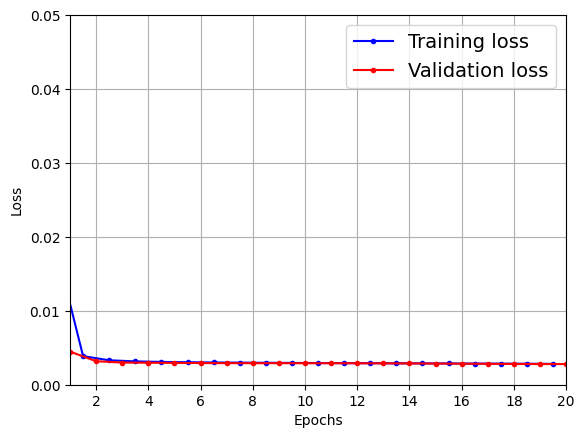

In [28]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


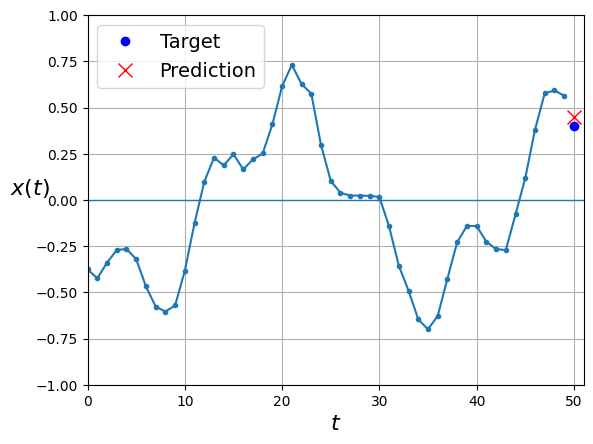

In [29]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Creating Deep Network with RNN returning only last output
For this set the return sequence=True for first layer and dont set for other layers
the last layer also is Dense in this case; as the RNN is presumably uses hidden state of other layers to carry over the information. Also RNN uses tanh activation, the values range between -1 and +1. Putting Dense layer makes the network perform little faster. Also you can choose the activation function of your choice.

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0773 - val_loss: 0.0053
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/ste

In [32]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025


0.002642292296513915

MSE is 0.0026 which is much better than other networks we have seen so far.

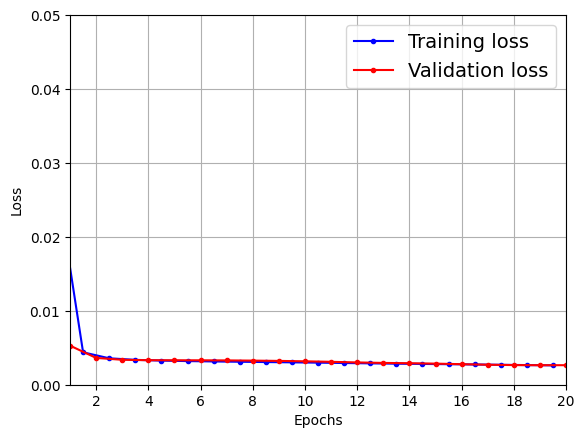

In [33]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


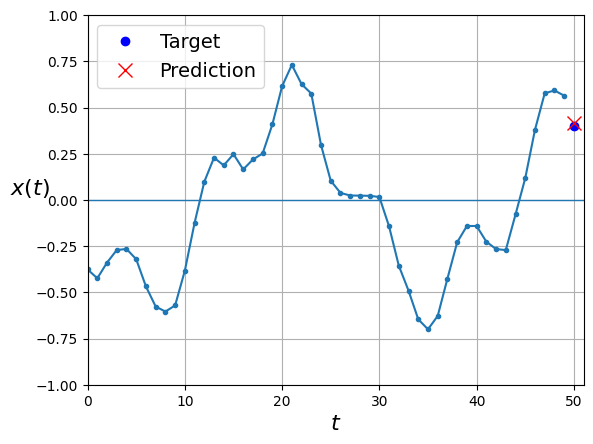

In [34]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

# Forecasting several time steps ahead
Predicting 10 values way before.

Option 1: Use the trained model to predict the next value and then add this predicted value to input and predict next and so on... <br>

In [46]:
np.random.seed(43)
series = generate_time_series(1, n_steps+10)

In [47]:
X_new, Y_new=series[:, :n_steps], series[:, n_steps:]
X=X_new

# Get step ahead and predict the value 10 times. Add predicted value to input again to make next prediction
for step_ahead in range(10):
  y_pred_one=model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X=np.concatenate([X, y_pred_one], axis=1)

Y_pred=X[:, n_steps:]
Y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


array([[[ 0.56381565],
        [ 0.5859629 ],
        [ 0.5275983 ],
        [ 0.39902622],
        [ 0.21634108],
        [ 0.02210754],
        [-0.12949868],
        [-0.2307911 ],
        [-0.29513517],
        [-0.3257014 ]]], dtype=float32)

In [48]:
Y_pred.shape

(1, 10, 1)

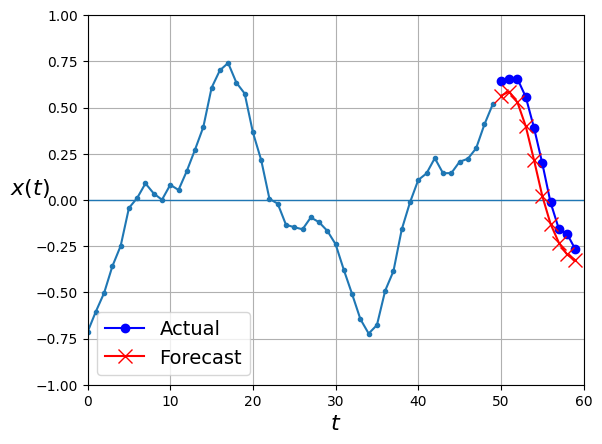

In [49]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [51]:
np.mean(keras.metrics.mse(Y_valid, Y_pred))

np.float32(0.28941238)

In [53]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mse(Y_valid, Y_naive_pred))

np.float32(0.25697407)

Option 2: Train RNN to predict all 10 values at once. We can use Sequence to Vector model but instead of 1 it will predict 10 values. <br>
To do that before we need to create targets to vectors containing the next 10 values.

In [41]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]
X_sample, y_sample = series[:50, :n_steps], series[:50, -10:, 0]

In [40]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [44]:
X_sample[1]

array([[ 0.2655248 ],
       [ 0.23108748],
       [ 0.03770885],
       [-0.03080609],
       [-0.17988688],
       [-0.31881845],
       [-0.46522513],
       [-0.5637513 ],
       [-0.5580675 ],
       [-0.43465146],
       [-0.3046509 ],
       [-0.1521073 ],
       [ 0.12169014],
       [ 0.33661968],
       [ 0.54001147],
       [ 0.6530332 ],
       [ 0.7231088 ],
       [ 0.6870334 ],
       [ 0.4791239 ],
       [ 0.36695585],
       [ 0.06045676],
       [-0.18181656],
       [-0.3735148 ],
       [-0.5557579 ],
       [-0.622744  ],
       [-0.6718724 ],
       [-0.58777   ],
       [-0.46400538],
       [-0.21696734],
       [ 0.02887913],
       [ 0.19160746],
       [ 0.37201372],
       [ 0.45309448],
       [ 0.546951  ],
       [ 0.44949853],
       [ 0.43388122],
       [ 0.28403777],
       [ 0.11527138],
       [ 0.06192801],
       [-0.09399972],
       [-0.17760696],
       [-0.2306893 ],
       [-0.27720088],
       [-0.28476682],
       [-0.2779141 ],
       [-0

In [45]:
y_sample[1]

array([0.0051308 , 0.08580116, 0.20665818, 0.35378858, 0.3838966 ,
       0.4867545 , 0.4927417 , 0.43097195, 0.21307838, 0.13890865],
      dtype=float32)

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1080 - val_loss: 0.0264
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0242 - val_loss: 0.0176
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0163 - val_loss: 0.0167
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0136 - val_loss: 0.0156
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0124 - val_loss: 0.0143
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0116 - val_loss: 0.0129
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


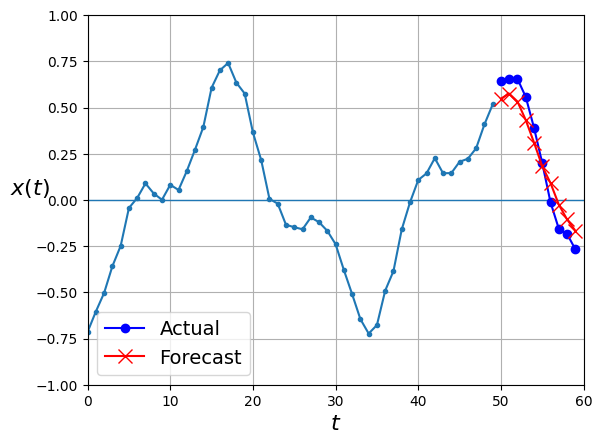

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

this model works well. the mse for next 10 steps is 0.008.

Option 3: We can even go further and predict 10 values using sequence to sequence model. <br>
The advantage of this approach is that the loss will contain a term for output of the RNN at each and every time step, not just output at the last step. This means there will be many more error gradient flowing through the mode. And they will not have flow through time; they will also flow from the output of each time step. This will both stablize and speed up the training process.

<br>
To be clear at timestep 0, the model will output vector containing forecast for timestep 1 to 10 <br>
at timestep 1, the model will output vector containing forecast for timestep 2 to 11. <br>
and so on

In [57]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

# Split the train, val and test set
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

# create target a sequence of 10D vectors
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [58]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mse(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - last_time_step_mse: 0.0716 - loss: 0.0764 - val_last_time_step_mse: 0.0315 - val_loss: 0.0429
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0328 - loss: 0.0430 - val_last_time_step_mse: 0.0193 - val_loss: 0.0327
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0211 - loss: 0.0330 - val_last_time_step_mse: 0.0146 - val_loss: 0.0271
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0162 - loss: 0.0280 - val_last_time_step_mse: 0.0117 - val_loss: 0.0242
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0122 - loss: 0.0248 - val_last_time_step_mse: 0.0091 - val_loss: 0.0211
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0103 - loss: 0.0225 - val_last_time_step_mse: 0.0087 - val_loss: 0.0206
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0091 - loss: 0.0215 - val_last_time_step_mse

In [62]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, None, 20)       │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, None, 20)       │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 10)       │           210 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,412 (17.24 KB)

 Trainable params: 1,470 (5.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,942 (11.50 KB)

In [60]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


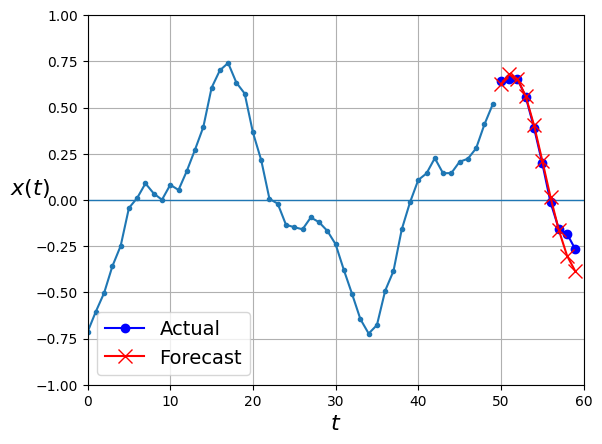

In [61]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Handling Long Sequences

## Unstable Gradient Problem

### Batch Normalization Technique
To tackle this there are many options available. However, Relu cannot be used with Deep RNN. <br>
Below is using Batch Normalization Technique

In [63]:
np.random.seed(42)
tf.random.set_seed(42)

# add batch normalization layer between the layers. BN is not possible between timesteps
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - last_time_step_mse: 0.4114 - loss: 0.4205 - val_last_time_step_mse: 0.0760 - val_loss: 0.0832
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0435 - loss: 0.0542 - val_last_time_step_mse: 0.0473 - val_loss: 0.0556
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0369 - loss: 0.0471 - val_last_time_step_mse: 0.0362 - val_loss: 0.0462
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0334 - loss: 0.0439 - val_last_time_step_mse: 0.0315 - val_loss: 0.0423
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0308 - loss: 0.0415 - val_last_time_step_mse: 0.0284 - val_loss: 0.0397
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - last_time_step_mse: 0.0286 - loss: 0.0396 - val_last_time_step_mse: 0.0260 - val_loss: 0.0377
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0265 - loss: 0.0377 - val_last_time_step_m

### Deep RNN with Layer Normalization

In [64]:
from tensorflow.keras.layers import LayerNormalization

In [67]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [72]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [73]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - last_time_step_mse: 0.2227 - loss: 0.2262 - val_last_time_step_mse: 0.0447 - val_loss: 0.0619
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0425 - loss: 0.0581 - val_last_time_step_mse: 0.0338 - val_loss: 0.0505
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - last_time_step_mse: 0.0341 - loss: 0.0495 - val_last_time_step_mse: 0.0289 - val_loss: 0.0450
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0290 - loss: 0.0442 - val_last_time_step_mse: 0.0249 - val_loss: 0.0405
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0245 - loss: 0.0398 - val_last_time_step_mse: 0.0208 - val_loss: 0.0361
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0205 - loss: 0.0355 - val_last_time_step_mse: 0.0180 - val_loss: 0.0328
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0179 - loss: 0.0328 - val_la